**Goal**:
- Allow the spatial model to include local vaccinations
    - From the data
    - From a prediction into the future (many scenarios possible, but keep it simple). This is included in the `__call__` function of the `make_vaccination_function`, 
- Allow the model to include local measures (no priority)
- Allow the model to include local spread of VOCs (no priority)
- Main question: what is the distribution of hospitalisations in Belgium and how is this linked to the degree of vaccination?
- Side questions
    - How does the increase in Brussels affect the rest of the country?
    - How can this be alleviated with local measures? How is this different from national measures?
    - How can this be alleviated with isolation of Brussels?
    - How would the situation have been if Brussels was vaccinated as the rest-of-the-country average? And if Belgium was vaccinated as Brussels? 

**Remarks**

- Why are the vaccine-eligible subjects only those from class S and R? Would make sense to also include E and A
- Why do subjects from R become dS_v?
- `dD_v = (m_ICU/dICU_D)*ICU_v + (m_C/dc_D)*C_v` seems incomplete, unless the chance of dying once a subject is hospitalised is the same with or without vaccination. Not sure if there is data available on this.
- Note: `N_vacc` must be age and space stratified. It is not yet obvious how this is implemented into the main model (we'd have to dig deep into the code). The same problem goes with `Nc` if we are to stratify this spatially (per province).
- What type of vaccination does `get_public_spatial_vaccination_data` return? First vaccination, I suppose?
- `Nc` in params is no longer used
- Why don't we use CoMix data?

# Load packages and functions

In [1]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19_DTM.models.TDPF import make_mobility_update_function, make_contact_matrix_function, make_VOC_function, make_N_vacc_function
from covid19_DTM.models.utils import initial_state
# from covid19_DTM.optimization.run_optimization import checkplots, calculate_R0
# from covid19_DTM.optimization.objective_fcns import prior_custom, prior_uniform
from covid19_DTM.data import mobility, sciensano, model_parameters
# from covid19_DTM.optimization import pso, objective_fcns
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.visualization.optimization import autocorrelation_plot, traceplot

import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19_DTM` package is under construction
%autoreload 2

# Copied from mrollier-calibration-WAVE2_spatial.ipynb
import gc
import sys, getopt
import os
import json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

from covid19_DTM.data import mobility, sciensano, model_parameters, VOC
from covid19_DTM.models.TDPF import ramp_fun, make_VOC_function, make_seasonality_function
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.visualization.optimization import autocorrelation_plot, traceplot
from covid19_DTM.models.utils import initial_state


agg='prov'

In [2]:
# Total population and contact matrices
Nc_dict = model_parameters.get_integrated_interaction_matrices()

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data = mobility.get_proximus_mobility_data(agg)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Load and format national VOC data (for time-dependent VOC fraction)
df_VOC_abc = VOC.get_abc_data()
df_VOC_delta = VOC.get_delta_data()

# Load and format local vaccination data
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)

initN, Nc_dict, pars_dict, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial=agg)

values = 'hospitalised_IN'
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values=values, moving_avg=False)


### TIME-DEPENDENT FUNCTIONS ###
# Define time-dependent social contact matrix
contact_matrix_function = make_contact_matrix_function(df_google, Nc_dict)
ramp_fun = make_contact_matrix_function(df_google, Nc_dict).ramp_fun
# Covers the entire pandemic period

# policies_WAVE2_no_relaxation = make_contact_matrix_function(df_google, Nc_dict).policies_WAVE2_no_relaxation
# policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_dict).policies_WAVE2_full_relaxation
policies_all = make_contact_matrix_function(df_google, Nc_dict).policies_all

# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data).mobility_wrapper_func

# function to update VOC fraction
VOC_function = make_VOC_function(df_VOC_abc)

# function to update local vaccination level (first dose only)
vaccination_function = make_vaccination_function(public_spatial_vaccination_data['CUMULATIVE'])
# sciensano_spatial_first_dose = vaccination_function.get_sciensano_spatial_first_dose

AttributeError: module 'covid19_DTM.data.model_parameters' has no attribute 'get_COVID19_SEIQRD_parameters'

# Nice visualisation of VOC and their effect on infectivity

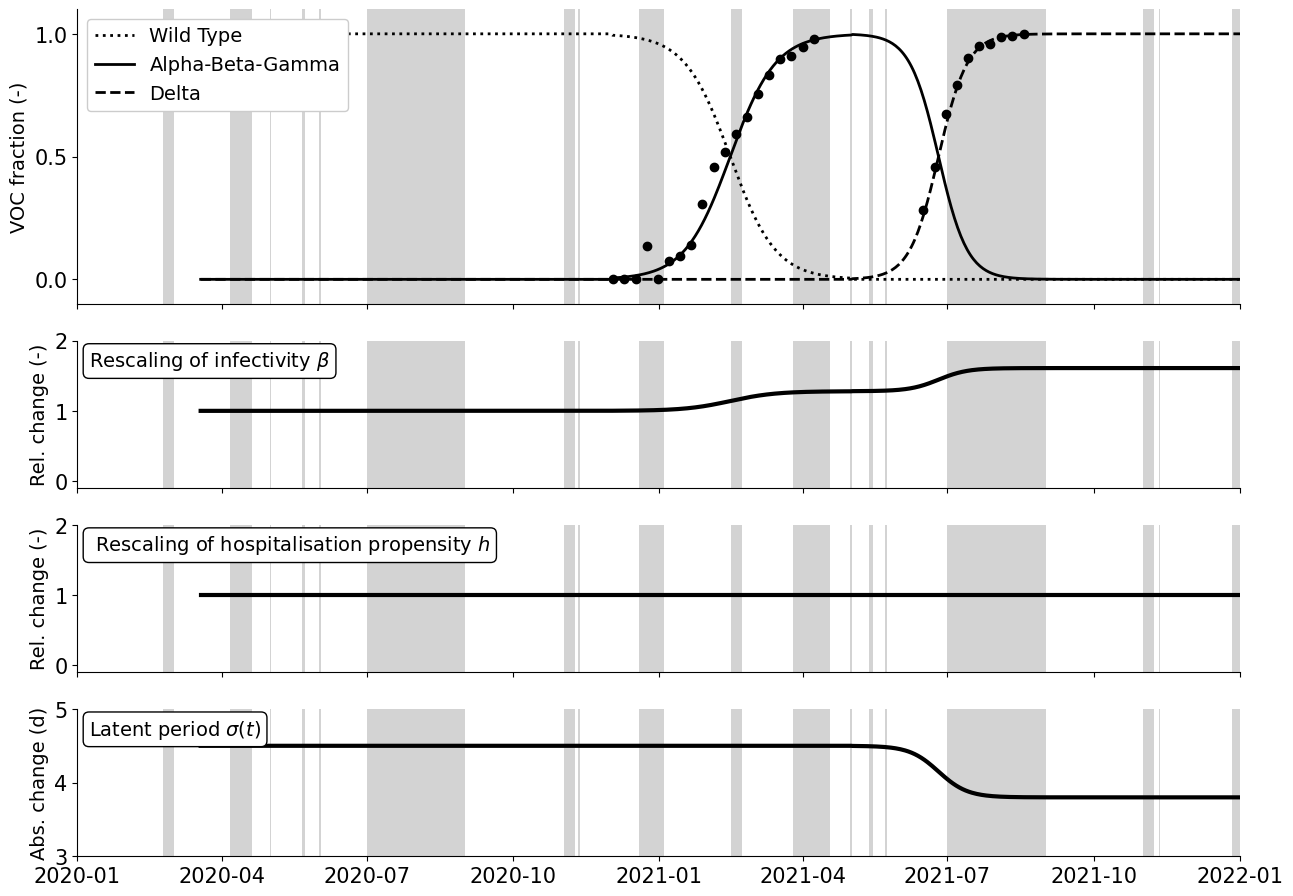

In [3]:
# I SUPPOSE THIS DATA DOES NOT EXIST ON A PROVINCIAL LEVEL?

from covid19_DTM.visualization.utils import moving_avg
from covid19_DTM.visualization.output import *

df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
sciensano_df_public = moving_avg(df_hosp[['H_in']].groupby('date').sum(), dropna=True)
sciensano_values_public = sciensano_df_public.values
sciensano_dates_public = sciensano_df_public.index + pd.Timedelta(hours=12)
VOC_params, vaccine_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(VOCs=['WT','abc','delta'])

VOC_function = make_VOC_function(VOC_params['logistic_growth'])
states = 0
param = 0

VOCs = np.zeros([len(sciensano_dates_public),3])
for i, t in enumerate(sciensano_dates_public):
    VOCs[i] = VOC_function(t, states, param)[0,:]
    
start_date = datetime.datetime(2020, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,11), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})
ticklabelsize = 14

# VOC fraction
ylim=1.1
# Overlay hospitalisations
axs[0].plot(sciensano_dates_public, VOCs[:,0], linewidth=2, color='black', linestyle='dotted')
axs[0].plot(sciensano_dates_public, VOCs[:,1], linewidth=2, color='black')
axs[0].plot(sciensano_dates_public, VOCs[:,2], linewidth=2, color='black', linestyle='dashed')
axs[0].scatter(df_VOC_abc.index, df_VOC_abc, color='k')
axs[0].scatter(df_VOC_delta.index, df_VOC_delta, color='k')
axs[0].set_ylabel('VOC fraction (-)', size=ticklabelsize)
axs[0].legend(['Wild Type', 'Alpha-Beta-Gamma', 'Delta'], loc='upper left', framealpha=1, fontsize=ticklabelsize)
axs[0].set_ylim(-0.1, ylim)
axs[0].set_yticks([0,0.5,1])

# Rescaling of beta
K_inf = np.array([1, 1.28, 1.61])
K_eff = np.matmul(VOCs, K_inf)
axs[1].plot(sciensano_dates_public, K_eff, color='black')
axs[1].set_ylim([-0.1,2])
axs[1].set_yticks([0,1,2])
axs[1].set_ylabel('Rel. change (-)', size=ticklabelsize)

# Rescaling of h
h_list = np.array([1, 1, 1])
h = np.matmul(VOCs, h_list)
axs[2].plot(sciensano_dates_public, h, color='black')
axs[2].set_ylim([-0.1,2])
axs[2].set_yticks([0,1,2])
axs[2].set_ylabel('Rel. change (-)', size=ticklabelsize)

# Rescaling latent period
sigma_list = np.array([4.5, 4.5, 3.8])
sigma = np.matmul(VOCs, sigma_list)
axs[3].plot(sciensano_dates_public, sigma, color='black')
axs[3].set_ylim([3,5])
axs[3].set_yticks([3,4,5])
axs[3].set_ylabel('Abs. change (d)', size=ticklabelsize)

# Decoration

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

axs[0].set_xlim(start_date, end_date)
axs[1].set_xlim(start_date, end_date)
axs[2].set_xlim(start_date, end_date)
axs[3].set_xlim(start_date, end_date)

week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
color_timeframes(start_date, end_date, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[2], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[3], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

props = dict(boxstyle='round', facecolor='white', alpha=1)
titles = ['Rescaling of infectivity $\\beta$', ' Rescaling of hospitalisation propensity $h$', 'Latent period $\\sigma(t)$']
for i in range(3):
    # place a text box in upper left in axes coords
    axs[i+1].text(0.01, 0.94, titles[i], transform=axs[i+1].transAxes, fontsize=ticklabelsize,
        verticalalignment='top', bbox=props)

plt.savefig('VOC_prevalence.pdf', bbox_inches='tight')

# Nice visualisation of vaccination and its effect

## Plot raw cumulative data

             INCIDENCE                                                  \
NIS              10000       20001       20002       21000       30000   
date                                                                     
2020-12-28  232.000000  174.428571  141.428571  548.857143  341.285714   
2020-12-29  363.026786  238.410714  149.187500  579.910714  455.098214   
2020-12-30  485.864397  298.393973  156.461496  609.023438  561.797433   
2020-12-31  601.024658  354.628278  163.280866  636.316616  661.827951   
2021-01-01  708.987403  407.347940  169.674026  661.903970  755.606561   
...                ...         ...         ...         ...         ...   
2022-04-28   17.726678   17.647954    5.114559   26.638295   12.190834   
2022-04-29   16.618760   16.544957    4.794899   24.973402   11.428907   
2022-04-30   15.580088   15.510897    4.495218   23.412564   10.714600   
2022-05-01   14.606332   14.541466    4.214267   21.949279   10.044937   
2022-05-02   13.693437   13.632624    

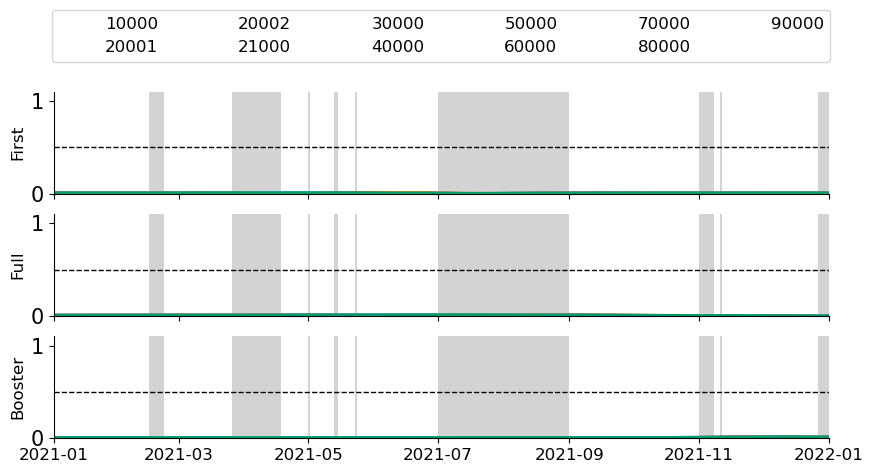

In [16]:
from covid19_DTM.visualization.utils import moving_avg
from covid19_DTM.visualization.output import *
from covid19_DTM.models.TDPF import make_N_vacc_function
from covid19_DTM.data.utils import construct_initN

# Get initN
age_classes = age_classes = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
initN = construct_initN(age_classes, agg='prov')
# Make the vaccination function
df = sciensano.get_public_spatial_vaccination_data(update=False,agg='prov')
vaccination_function = make_N_vacc_function(df['INCIDENCE'], age_classes=age_classes, agg='prov')

df = vaccination_function.df.groupby(['dose', 'date', 'NIS']).sum()
df = df.reset_index()
df_A = df[df['dose']=='A'].drop(columns=['dose']).rename(columns={0:'dose'})
df_B = df[df['dose']=='B'].drop(columns=['dose']).rename(columns={0:'dose'})
df_C = df[df['dose']=='C'].drop(columns=['dose']).rename(columns={0:'dose'})
df_E = df[df['dose']=='E'].drop(columns=['dose']).rename(columns={0:'dose'})

df_A = pd.pivot_table(df_A, index=['date', 'NIS'], values='INCIDENCE').unstack() # first dose
df_B = pd.pivot_table(df_B, index=['date', 'NIS'], values='INCIDENCE').unstack() # second dose
df_C = pd.pivot_table(df_C, index=['date', 'NIS'], values='INCIDENCE').unstack() # Janssen dose
df_E = pd.pivot_table(df_E, index=['date', 'NIS'], values='INCIDENCE').unstack() # booster dose

vacc_A = np.zeros([len(df_A.index),11])
vacc_B = np.zeros([len(df_B.index),11])
vacc_C = np.zeros([len(df_C.index),11])
vacc_E = np.zeros([len(df_E.index),11])
for i, t in enumerate(df_A.index):
    vacc_A[i] = df_A.values[i]
    vacc_B[i] = df_B.values[i]
    vacc_C[i] = df_C.values[i]
    vacc_E[i] = df_E.values[i]

start_date = datetime.datetime(2021, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)
    
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,4.5), sharex=True)
ticklabelsize = 12
axs[0].set_xlim(start_date, end_date)
axs[0].set_ylim(0, 1.1)#1.6e6)
axs[1].set_ylim(0, 1.1)#.6)
axs[2].set_ylim(0, 1.1)#.6)

axs[0].set_ylabel('First', size=ticklabelsize)
axs[1].set_ylabel('Full', size=ticklabelsize)
axs[2].set_ylabel('Booster', size=ticklabelsize)

# Overlay vaccinations
# ax.stackplot(df_A.index, vacc_A.T, labels=['wild type', '$\\alpha/\\beta/\\gamma$', '$\\delta$'])

week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
color_timeframes(start_date, end_date, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[2], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Download total population per province (aggregated over all ages)
initN_values = initN.sum(axis=1).values

# ax.stackplot(df_A.index, vacc_A.T, labels=['a', 'b'], alpha=0.8)
# Add Janssen vaccination to second-dose vaccination
axs[0].plot(df_A.index, (vacc_A-vacc_B)/initN_values)
axs[1].plot(df_B.index, (vacc_B+vacc_C-vacc_E)/initN_values)
axs[2].plot(df_E.index, vacc_E/initN_values)

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

axs[0].axhline(0.5, linestyle='--', color='k', linewidth=1)
axs[1].axhline(0.5, linestyle='--', color='k', linewidth=1)
axs[2].axhline(0.5, linestyle='--', color='k', linewidth=1)

plt.xticks(rotation=0, size=ticklabelsize)

axs[0].legend(df.groupby('NIS').sum().index.values, loc='center', bbox_to_anchor=(0.5, 1.55), ncol=6, fontsize=ticklabelsize)

# axs[0].set_title('test')

# plt.savefig('vaccination_timeseries.png', dpi=400, bbox_inches='tight')

## Calculate exponential waning function

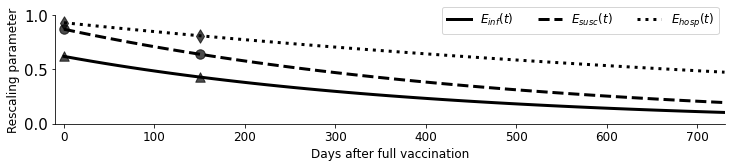

In [37]:
def exponential_waning(delta_t, waning_days, E_best, E_waned):
    """
    Function to compute the vaccine efficacy after delta_t days, accouting for exponential waning of the vaccine's immunity.

    Input
    -----
    days : float
        number of days after the novel vaccination
    waning_days : float
        number of days for the vaccine to wane (on average)
    E_best : float
        rescaling value related to the best possible protection by the currently injected vaccine
    E_waned : float
        rescaling value related to the vaccine protection after a waning period.

    Output
    ------
    E_eff : float
        effective rescaling value associated with the newly administered vaccine

    """

    if E_best == E_waned:
        return E_best
    # Exponential waning
    A0 = E_best
    k = -np.log((E_waned)/(E_best))/(waning_days)
    E_eff = A0*np.exp(-k*(delta_t))

    return E_eff

ticklabelsize=12

# E_s
E_susc_best = 0.87
E_susc_waned = 0.64
# E_inf
E_inf_best = 0.62
E_inf_waned = 0.43
# E_hosp
E_hosp_best = 0.93
E_hosp_waned = 0.81

waning_inf_delay=[]
waning_susc_delay=[]
waning_hosp_delay=[]

waning_days=150
timespan=np.linspace(start=0,stop=365*2)

for t in timespan:
    waning_inf_delay.append(exponential_waning(t, waning_days, E_inf_best, E_inf_waned))
    waning_susc_delay.append(exponential_waning(t, waning_days, E_susc_best, E_susc_waned))
    waning_hosp_delay.append(exponential_waning(t, waning_days, E_hosp_best, E_hosp_waned))

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(timespan, waning_inf_delay, color='black')
ax.plot(timespan, waning_susc_delay, color='black', linestyle='--')
ax.plot(timespan, waning_hosp_delay, color='black', linestyle=':')
ax.scatter([0, waning_days],[E_inf_best, E_inf_waned], marker='^', color='black', s=90, alpha=0.7)
ax.scatter([0, waning_days],[E_susc_best, E_susc_waned], marker='o', color='black', s=90, alpha=0.7)
ax.scatter([0, waning_days],[E_hosp_best, E_hosp_waned], marker='d', color='black', s=90, alpha=0.7)
ax.grid(False)
ax.set_xlim([-10,365*2])
ax.set_xlabel('Days after full vaccination', size=ticklabelsize)
ax.set_ylabel('Rescaling parameter', size=ticklabelsize)

ax.set_ylim([0, 1])
#ax.axvline(150, 0, 1, linestyle='--', color='k', linewidth=1)
# ax.set_title('Effect of vaccine waning', size=ticklabelsize+2)

_ = plt.xticks(rotation=0, size=ticklabelsize)

labels=['$E_{inf}(t)$', '$E_{susc}(t)$', '$E_{hosp}(t)$']
ax.legend(labels, fontsize=ticklabelsize, ncol=3, loc='right', bbox_to_anchor=(1, 0.95))

# ax.legend(['$E_{susc}(t)$'], fontsize=ticklabelsize, loc='center', bbox_to_anchor=(0.12, 0.95))

plt.savefig('effect_of_waning_delayed.pdf', bbox_inches='tight')

## Rescaling parameters without waning

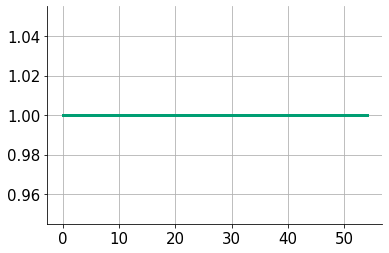

In [10]:
# Calculate relative population in vaccination state A, B, E

df_inc = sciensano.get_public_spatial_vaccination_data(update=False,agg='prov')
# vaccination_function_inc = make_vaccination_function(df_inc['INCIDENCE'])

df_inc = vaccination_function_inc.df.groupby(['dose', 'date', 'NIS']).sum()
df_inc = df_inc.reset_index()
df_inc_A = df_inc[df_inc['dose']=='A'].drop(columns=['dose']).rename(columns={0:'doses'}) # first dose
df_inc_B = df_inc[df_inc['dose']=='B'].drop(columns=['dose']).rename(columns={0:'doses'}) # second dose
df_inc_C = df_inc[df_inc['dose']=='C'].drop(columns=['dose']).rename(columns={0:'doses'}) # Janssen
df_inc_E = df_inc[df_inc['dose']=='E'].drop(columns=['dose']).rename(columns={0:'doses'}) # booster

df_inc_A = pd.pivot_table(df_inc_A, index=['date', 'NIS'], values='doses').unstack()
df_inc_B = pd.pivot_table(df_inc_B, index=['date', 'NIS'], values='doses').unstack()
df_inc_C = pd.pivot_table(df_inc_C, index=['date', 'NIS'], values='doses').unstack()
df_inc_E = pd.pivot_table(df_inc_E, index=['date', 'NIS'], values='doses').unstack()

vacc_inc_A = np.zeros([len(df_inc_A.index),11])
vacc_inc_B = np.zeros([len(df_inc_B.index),11])
vacc_inc_C = np.zeros([len(df_inc_C.index),11])
vacc_inc_E = np.zeros([len(df_inc_E.index),11])
for i, t in enumerate(df_inc_A.index):
    vacc_inc_A[i] = df_inc_A.values[i]
    vacc_inc_B[i] = df_inc_B.values[i]
    vacc_inc_C[i] = df_inc_C.values[i]
    vacc_inc_E[i] = df_inc_E.values[i]

# Download total population per province (aggregated over all ages)
initN_values = initN.sum(axis=1).values

# Create daily fraction of people compared to entire population
vacc_inc_A /= initN_values
vacc_inc_B /= initN_values
vacc_inc_C /= initN_values
vacc_inc_E /= initN_values

# Create cumulative nonvaxx fractions. Can't get second shot or Janssen nor booster.
vacc_non_sum = 1-np.cumsum(vacc_inc_A + vacc_inc_C, axis=0)

# Create cumulative single-vaxx-only fraction. Hors catégorie when second shot is administered. Can't get booster or Janssen.
vacc_inc_A_sum = np.cumsum(vacc_inc_A - vacc_inc_B, axis=0)

# Create cumulative full-vaxx fraction. Includes Janssen. Hors catégorie when booster administered.
vacc_inc_full_sum = np.cumsum(vacc_inc_B + vacc_inc_C - vacc_inc_E, axis=0)

# Create cumulative booster. Can only get booster when full-vaxx
vacc_inc_E_sum = np.cumsum(vacc_inc_E, axis=0)

# Sanity check: people are always in SOME category
sanity_check = plt.plot(vacc_non_sum + vacc_inc_A_sum + vacc_inc_full_sum + vacc_inc_E_sum)

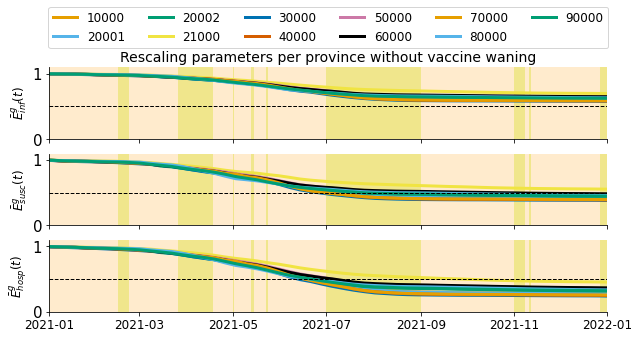

In [11]:
# Without waning: take weighed average of all rescaling factors
E_inf_bar_no_waning = vacc_non_sum * 1 + vacc_inc_A_sum * 0.75 + vacc_inc_full_sum * 0.50 + vacc_inc_E_sum * 0.50
E_susc_bar_no_waning = vacc_non_sum * 1 + vacc_inc_A_sum * 0.42 + vacc_inc_full_sum * 0.27 + vacc_inc_E_sum * 0.27
E_hosp_bar_no_waning = vacc_non_sum * 1 + vacc_inc_A_sum * 0.46 + vacc_inc_full_sum * 0.10 + vacc_inc_E_sum * 0.10

start_date = datetime.datetime(2021, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)
    
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,4.5), sharex=True)
ticklabelsize = 12
axs[0].set_xlim(start_date, end_date)
axs[0].set_ylim(0, 1.1)
axs[1].set_ylim(0, 1.1)
axs[2].set_ylim(0, 1.1)

axs[0].set_ylabel('$\\bar{E}_{inf}^g(t)$', size=ticklabelsize)
axs[1].set_ylabel('$\\bar{E}_{susc}^g(t)$', size=ticklabelsize)
axs[2].set_ylabel('$\\bar{E}_{hosp}^g(t)$', size=ticklabelsize)

# Overlay vaccinations
# ax.stackplot(df_A.index, vacc_A.T, labels=['wild type', '$\\alpha/\\beta/\\gamma$', '$\\delta$'])

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[2], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# ax.stackplot(df_A.index, vacc_A.T, labels=['a', 'b'], alpha=0.8)
axs[0].plot(df_A.index, E_inf_bar_no_waning)
axs[1].plot(df_A.index, E_susc_bar_no_waning)
axs[2].plot(df_B.index, E_hosp_bar_no_waning)

axs[0].axhline(0.5, linestyle='--', color='k', linewidth=1)
axs[1].axhline(0.5, linestyle='--', color='k', linewidth=1)
axs[2].axhline(0.5, linestyle='--', color='k', linewidth=1)

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

axs[0].legend(df.groupby('NIS').sum().index.values, loc='center', bbox_to_anchor=(0.5, 1.55), ncol=6, fontsize=ticklabelsize)

axs[0].set_title('Rescaling parameters per province without vaccine waning', size=ticklabelsize+2)

_ = plt.xticks(rotation=0, size=ticklabelsize)

## Rescaling parameters with waning

Now we expect the above graph to spawn again, with the difference that all values will start rising again in the second half of 2021, and then lowered again due to booster shots.

This is put in effect by making the rescaling parameter after full vaccination time-dependent.

In [12]:
# now the rescaling parameter for full vaccination becomes time-dependent!

E_inf_bar = np.zeros([len(df_A.index),11])
E_susc_bar = np.zeros([len(df_A.index),11])
E_hosp_bar = np.zeros([len(df_A.index),11])

E_inf_bar_full = np.zeros([len(df_A.index),11])
E_susc_bar_full = np.zeros([len(df_A.index),11])
E_hosp_bar_full = np.zeros([len(df_A.index),11])

E_inf_init = 0.50
E_inf_waned = 0.50
E_susc_init = 0.27
E_susc_waned = 0.53
E_hosp_init = 0.10
E_hosp_waned = 0.12

vacc_inc_BC = vacc_inc_B + vacc_inc_C
vacc_inc_BC_sum = np.cumsum(vacc_inc_BC,axis=0)
for i in range(len(df_A.index)):
    sum_E_inf = np.zeros([1,11])
    sum_E_susc = np.zeros([1,11])
    sum_E_hosp = np.zeros([1,11])
    for j in range(0,i+1):
        # index is in terms of weeks; waning_exp in terms of days
        sum_E_inf += vacc_inc_BC[j] * waning_exp((i-j)*7, E_inf_init, E_inf_waned)
        sum_E_susc += vacc_inc_BC[j] * waning_exp((i-j)*7, E_susc_init, E_susc_waned)
        sum_E_hosp += vacc_inc_BC[j] * waning_exp((i-j)*7, E_hosp_init, E_hosp_waned)
    E_inf_bar_full[i] = sum_E_inf / vacc_inc_BC_sum[i]
    E_susc_bar_full[i] = sum_E_susc / vacc_inc_BC_sum[i]
    E_hosp_bar_full[i] = sum_E_hosp / vacc_inc_BC_sum[i]


E_inf_bar = vacc_non_sum * 1 + vacc_inc_A_sum * 0.75 + vacc_inc_full_sum * E_inf_bar_full + vacc_inc_E_sum * 0.50
E_susc_bar = vacc_non_sum * 1 + vacc_inc_A_sum * 0.42 + vacc_inc_full_sum * E_susc_bar_full + vacc_inc_E_sum * 0.27
E_hosp_bar = vacc_non_sum * 1 + vacc_inc_A_sum * 0.46 + vacc_inc_full_sum * E_hosp_bar_full + vacc_inc_E_sum * 0.10

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


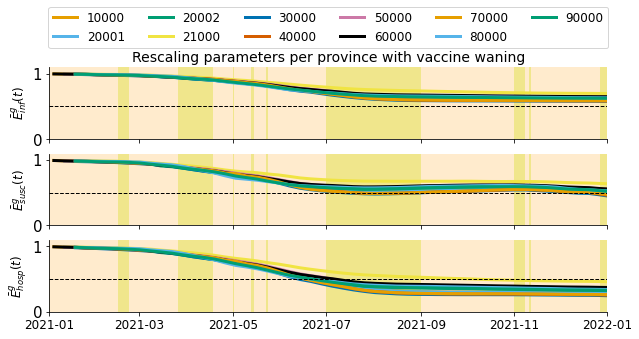

In [14]:
start_date = datetime.datetime(2021, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)
    
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,4.5), sharex=True)
ticklabelsize = 12
axs[0].set_xlim(start_date, end_date)
axs[0].set_ylim(0, 1.1)
axs[1].set_ylim(0, 1.1)
axs[2].set_ylim(0, 1.1)

axs[0].set_ylabel('$\\bar{E}_{inf}^g(t)$', size=ticklabelsize)
axs[1].set_ylabel('$\\bar{E}_{susc}^g(t)$', size=ticklabelsize)
axs[2].set_ylabel('$\\bar{E}_{hosp}^g(t)$', size=ticklabelsize)

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[2], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

axs[0].plot(df_A.index, E_inf_bar)
axs[1].plot(df_A.index, E_susc_bar)
axs[2].plot(df_B.index, E_hosp_bar)

axs[0].axhline(0.5, linestyle='--', color='k', linewidth=1)
axs[1].axhline(0.5, linestyle='--', color='k', linewidth=1)
axs[2].axhline(0.5, linestyle='--', color='k', linewidth=1)

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

axs[0].legend(df.groupby('NIS').sum().index.values, loc='center', bbox_to_anchor=(0.5, 1.55), ncol=6, fontsize=ticklabelsize)

axs[0].set_title('Rescaling parameters per province with vaccine waning', size=ticklabelsize+2)

_ = plt.xticks(rotation=0, size=ticklabelsize)

# plt.savefig('vaccine_rescaling_effect.png', dpi=400, bbox_inches='tight')

# Nice visualisation of seasonality

In [28]:
seasonality = make_seasonality_function()
states=0
param=1
amplitude=0.104
peak_shift=22.2

seasonality_array = np.zeros(len(sciensano_dates_public))
for i, t in enumerate(sciensano_dates_public):
    seasonality_array[i] = seasonality(t, states, param, amplitude, peak_shift)

start_date = datetime.datetime(2020, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)
    
fig, ax = plt.subplots(figsize=(10,2.5))
ticklabelsize = 12
ax.set_xlim(start_date, end_date)
ax.set_ylim(0.75, 1.25)
ax.set_yticks([0.8, 1, 1.2])

week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
color_timeframes(start_date, end_date, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

ax.plot(sciensano_dates_public, seasonality_array, color='darkred')
ax.hlines(1, pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1), colors='k', linestyle='--', linewidth=1)
ax.vlines(pd.Timestamp(2021, 1, 1), .75, 1.25, colors='k', linestyle='--', linewidth=1)

ax.set_ylabel('Relative infectivity', size=ticklabelsize)
plt.xticks(rotation=0, size=ticklabelsize)

ax.grid(False)

plt.savefig('seasonality_timeseries.pdf', bbox_inches='tight')

NameError: name 'sciensano_dates_public' is not defined